This is part of a three part hand-in to the M1-exam.

Link to this colab is https://colab.research.google.com/drive/1i7VYq8SgB5dFA8jNcMaVJBBHqsD43exI

**Preprocessing**

Importing libraries and fetching data

In [0]:
## Get data
!wget -c https://github.com/bande15/SDS_M1_EXAM/raw/master/combine_data.csv -O df.csv
  
## Mute Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning, Warning))

#Import General Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

#Install and import special libraries
!pip install catboost
from catboost import CatBoostClassifier

Reading and processing data; 
The analysis is trying to identify and predict position from physical stats, so all other data is dropped before missing values are dropped. Data is then converted to metric.

In [0]:
df = pd.read_csv('df.csv')
df_pre = df.drop(['Player','Pfr_ID','Year','AV'], 1)
df_pre = df_pre.dropna(how='any' , axis=0)
df = df.drop(['Player','Pfr_ID','Year','AV','Round','Pick','Team'], 1)
a = len(df)
df = df.dropna(how='any' , axis=0)
b = a - len(df)
a = len(df)
print(b , 'observations dropped due to missing values.', a ,'values left.' )
del a , b

3333 observations dropped due to missing values. 2885 values left.


We wil now count occurrences for each unique positon before and after observations with missing data is dropped.

In [0]:
df_old = pd.read_csv('df.csv')
a = df_old.Pos.value_counts()
b = df.Pos.value_counts()
print(a , b)

WR      857
CB      630
RB      540
DE      487
DT      463
OT      460
OLB     424
OG      365
QB      350
TE      337
ILB     276
FS      229
SS      213
C       171
P       120
FB      117
K        85
S        27
EDGE     23
LS       20
G        14
NT        3
LB        3
DB        2
OL        2
Name: Pos, dtype: int64 CB      311
DE      279
WR      275
OT      273
DT      253
RB      245
OLB     240
OG      224
TE      194
ILB     130
FS      123
C       115
SS      107
FB       77
QB       12
G         8
EDGE      8
S         7
LS        2
LB        1
OL        1
Name: Pos, dtype: int64


From the above lists of observations per position it becomes clear that  some positions have very few or no coherent observations. Not only does this prevent a 'coherent' analysis, but the option of simply scrappinf the observations, or konverting missing to zero, will not yield truthful results. This is a essential fundamentiil problem with the following analysis, and it will be discussed and in the shareholder's handout. The short version is, excludidng positions will not only prevent the models from predicting those positions, but also falsely associate some combination of stats with other positions, this yielding false results.

In [0]:
# Metric Conversion
def to_cm(F):
    return F*2.54
def to_kg(F):
    return F*0.45359237

df[['Ht','Vertical','BroadJump']] = df[['Ht','Vertical','BroadJump']].apply(to_cm)
df[['Wt']] = df[['Wt']].apply(to_kg)
df_pre[['Ht','Vertical','BroadJump']] = df_pre[['Ht','Vertical','BroadJump']].apply(to_cm)
df_pre[['Wt']] = df_pre[['Wt']].apply(to_kg)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 2 to 6217
Data columns (total 9 columns):
Pos          2885 non-null object
Ht           2885 non-null float64
Wt           2885 non-null float64
Forty        2885 non-null float64
Vertical     2885 non-null float64
BenchReps    2885 non-null float64
BroadJump    2885 non-null float64
Cone         2885 non-null float64
Shuttle      2885 non-null float64
dtypes: float64(8), object(1)
memory usage: 225.4+ KB


,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
2,OT,193.04,151.499852,5.56,63.50,23.0,238.76,8.48,4.98
7,OLB,182.88,107.501392,4.72,78.74,21.0,284.48,7.96,4.39
9,CB,175.26,79.378665,4.44,88.90,17.0,302.26,7.03,4.14
11,OT,198.12,141.520819,5.34,71.12,20.0,243.84,7.72,4.73
12,FS,182.88,94.347213,4.62,88.90,10.0,289.56,6.92,4.32


With the newly cleaned and metrified dataframe, we can now try to make some explorative data analysis.

First off, we can look at the different teams, asking the question:

How different are the teams?

This can be examined by grouping for the 'Team' variable, and taking the mean of relevant variables.

In [0]:
df_pre.groupby('Team')['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle','Round','Pick'].mean()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Round,Pick
Team,,,,,,,,,,
Arizona Cardinals,188.430370,117.379626,4.816296,83.631852,21.500000,287.537407,7.334444,4.451296,3.592593,99.518519
Atlanta Falcons,187.335410,113.360913,4.763115,84.736066,21.852459,293.890492,7.326066,4.423115,4.000000,118.295082
Baltimore Ravens,188.277500,115.403821,4.787969,83.661250,21.578125,289.917188,7.273594,4.388438,4.203125,132.656250
Buffalo Bills,188.729697,114.587054,4.802879,83.165758,21.742424,287.327879,7.280152,4.396364,4.015152,116.969697
Carolina Panthers,188.902258,117.099992,4.831774,83.205484,22.064516,286.897097,7.322258,4.397097,4.112903,122.290323
Chicago Bears,186.740800,109.959862,4.704000,84.277200,19.880000,293.116000,7.232600,4.355400,3.500000,101.780000
Cincinnati Bengals,189.018333,114.592552,4.763333,85.238167,23.200000,293.793333,7.264667,4.356167,3.966667,117.850000
Cleveland Browns,187.390690,113.632709,4.786207,84.783448,21.672414,290.523448,7.217414,4.390517,4.034483,116.741379
Dallas Cowboys,188.061600,112.926356,4.777000,83.997800,20.700000,290.169600,7.250200,4.363000,4.160000,125.780000


From above output it looks like the different teams *generally* have similar statistics. This might imply that the teams look for similar physical stats in their player picks. Thus it also becomes interesting to look at the different positions.

Similar to the above code, we can group by the position variable, 'Pos', and take the mean of the remaining relevant variables.

In [0]:
df_pre.groupby('Pos')['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle','Round','Pick'].mean()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Round,Pick
Pos,,,,,,,,,,
C,191.599403,137.953011,5.230000,72.352090,26.537313,259.800299,7.660746,4.610448,4.044776,123.328358
CB,180.534505,87.637315,4.469505,91.920541,14.797297,310.314775,6.924369,4.145495,3.675676,106.171171
DE,192.688723,121.642375,4.798085,85.110266,24.340426,292.978191,7.288564,4.403298,3.787234,112.111702
DT,190.376848,139.791670,5.068727,75.053152,28.096970,268.070061,7.669091,4.612242,3.654545,106.260606
FB,183.745909,110.243564,4.737045,84.339545,24.000000,288.751818,7.266136,4.347727,5.318182,164.931818
FS,184.603571,93.899020,4.542857,91.833095,16.178571,308.277381,6.976310,4.177619,4.023810,119.738095
ILB,186.548889,109.522958,4.710741,85.654444,22.851852,294.295062,7.142099,4.266173,4.160494,125.209877
LS,187.960000,104.779837,4.930000,73.660000,21.000000,299.720000,7.030000,4.330000,6.000000,189.000000
OG,192.923664,142.116376,5.249389,71.469008,26.526718,258.692214,7.825649,4.719084,4.137405,125.106870


From above output it becomes very clear, that players playing different positions also have different physical traits. One of the most extreme examples is the positions CB and OG. Looking at those two specific positions, it becomes clear that CB is generally smaller, lighter, can't take as many bench reps, but they can jump higher.

Those results points towards the following hypothesis:

**Player positions implies different skills, thus requiring different physical attributes.**



## Unsupervised learning
Focusing on above hypothesis, we can try to use unsupervised learning to see, if the data itself is capable of distinguishing the different players' positions based on their physical stats.

Thus our first step will be to make a new dataframe, df_u, based on the original dataframe, df, as defined earlier. Following this, we will be transforming the 'Pos' variable into dummy variables using the get_dummies function, specifying the drop_first statement as True.

In [0]:

df_u = pd.get_dummies(df, drop_first=True)
df_u.head()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Pos_CB,Pos_DE,Pos_DT,Pos_EDGE,Pos_FB,Pos_FS,Pos_G,Pos_ILB,Pos_LB,Pos_LS,Pos_OG,Pos_OL,Pos_OLB,Pos_OT,Pos_QB,Pos_RB,Pos_S,Pos_SS,Pos_TE,Pos_WR
2,193.04,151.499852,5.56,63.50,23.0,238.76,8.48,4.98,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,182.88,107.501392,4.72,78.74,21.0,284.48,7.96,4.39,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,175.26,79.378665,4.44,88.90,17.0,302.26,7.03,4.14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,198.12,141.520819,5.34,71.12,20.0,243.84,7.72,4.73,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12,182.88,94.347213,4.62,88.90,10.0,289.56,6.92,4.32,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


To avoid overspecification we reduce the dataset to 'fundamentals' by excluding stats that could be derived. That is to say, a player may be picked first for a specific position becaseu of physical stats, so including both physical stats and position, may lead to overspecification. Before running unsupervised machinelearning, we reduce the data to fundamental physical stats.

We will now be scaling our variables, by using the StandardScaler function. Scaling is important when using distance based models, as KMeans is. It can also be a good idea to scale your data, if the different variables have large differences in their values.

After scaling we use the elbow method on the inertias plot, to determine a rightful amount of clusters.

In [0]:
ks = range(1, 15)
inertias = []
scale = StandardScaler()
sample = df_u
scale.fit(sample)
samples = scale.transform(sample)

for i in ks:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

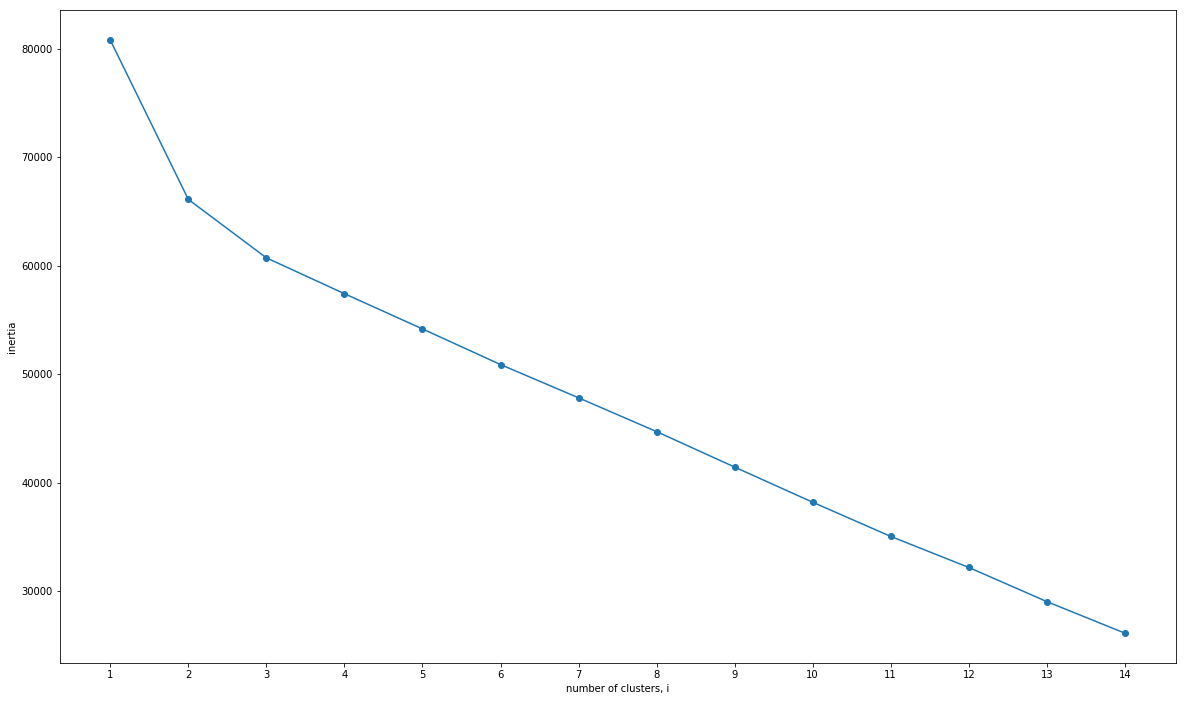

In [0]:
plt.figure(figsize=(20,12))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, i')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Looking at above plot we determine k clusters = 2, thus we want to use a total of 2 clusters.


In [0]:
model = KMeans(n_clusters=2)
model.fit(samples)
labels = model.predict(samples)

Now we want to use the PCA algorithm on our data. Principal components analysis is a hepful technique in order to make fundamental dimension reduction. Thus it helps us by showing how many PCA features we will include in further analysis.

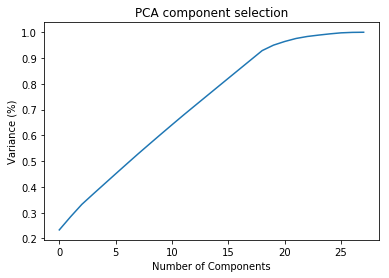

In [0]:

#Fitting the PCA algorithm with our Data
pca = PCA().fit(samples)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA component selection')
plt.show()

Looking at above plot of the explained variance, we choose 17 principal components. In comparison there are 20 different positions, with a few of them being practically identical.

Using 17 principal components, the clusters can now be made and plotted.

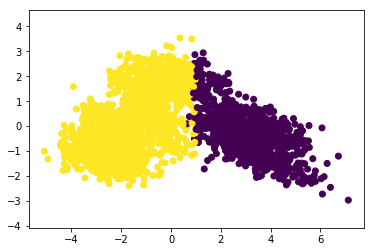

In [0]:
pca = PCA(n_components=17)
sample = pca.fit_transform(samples)
xs = sample[:,0]
ys = sample[:,1]
plt.scatter(xs, ys, c=labels)
plt.axis('equal')
plt.show()

Looking at above plot it seems like the algorithm is capable of splitting the observations into two well-defined and different clusters.

Following this, it could be very interesting to see, how the different player positions are spread throughout the clusters.

This can be examined using the crosstab function. In the following we have set normalize='index'. What this does is simply normalizing the different rows, thus summarizing the two clusters for any given position equals 1.

In [0]:
lab = pd.DataFrame(labels)
lab.columns = ['Clusters']
df_up = df_u.join(lab)
pd.crosstab(df.Pos,df_up.Clusters,normalize='index')

Clusters,0.0,1.0
Pos,,
C,0.333333,0.666667
CB,0.347107,0.652893
DE,0.333333,0.666667
DT,0.401869,0.598131
FB,0.511111,0.488889
FS,0.385714,0.614286
ILB,0.396825,0.603175
LS,1.000000,0.000000
OG,0.359649,0.640351


Even though most roles are represented more in one cluster than the other, even at a ratio of 2:1, it doesn't look like the clusters are particularly good at defining the different positions, thus the clusters are not particularly informative.


## Supervised learning
From unsupervised learning, it did not appear like the clusters were capable of splitting the players into different clusters based on their position. In the following code, we will try to use different supervised ML algorithms to see if this works any better at predicting what position a player has, based on how their physical traits are.


Thus the questions becomes: can we instead predict position by using some supervised machine learning models?

To run a supervised data analysis, the data is first converted to numeric, then scaled, and split into test and training datasets, with target variables seperated from the datasets.

In [0]:
supervised = df
supervised.head()

,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
2,OT,193.04,151.499852,5.56,63.50,23.0,238.76,8.48,4.98
7,OLB,182.88,107.501392,4.72,78.74,21.0,284.48,7.96,4.39
9,CB,175.26,79.378665,4.44,88.90,17.0,302.26,7.03,4.14
11,OT,198.12,141.520819,5.34,71.12,20.0,243.84,7.72,4.73
12,FS,182.88,94.347213,4.62,88.90,10.0,289.56,6.92,4.32


### Changing the position variable into a numerical variable
We want to use the position variable (Pos) as our target variable. Because the variable is categorical it is first needed to change it into a numerical variable.

In [0]:
posdict = {}
a = supervised.Pos.unique()
b = 0
while b < len(a):
  posdict[a[b]] = b
  b += 1
supervised['PosN'] = supervised['Pos'].map(posdict)

### Splitting data into test- and train-sets
We now want to split the X- and y-variables into a train- and test-set. We do this by using the train_test_split function from sklearn.model_selection. Before doing this, we want to use a scale (the StandardScaler() function).

Afterwards we split the data into a training and a test set. For this purpose we use a test size of 25%, and we specify a random_state value (42), so we can easily replicate our results.


In [0]:
encoder = LabelEncoder()
scaler = StandardScaler()
dataset = scaler.fit_transform(supervised.drop(['Pos','PosN'], 1))
target = encoder.fit_transform(supervised['PosN'])
train_data, test_data, train_target, test_target = train_test_split(dataset, target, test_size=0.20, random_state=42)

Now that the data has been split into a training and a test set, and it is scaled, we can use different models in order to predict how well the models perform.


###Linear Regression

In [0]:
# K-fold cross-validation
model1 = LinearRegression()
scores1 = cross_val_score(model1, train_data, train_target, cv = 5)
print("An average cross validation score of {}".format(np.mean(scores1)))

# Model training
model1.fit(train_data, train_target)

# Model performance
print('Model performance:', model1.score(test_data, test_target))

An average cross validation score of 0.045682350704720466
Model performance: 0.022602925239476157


Unsurprisingly the model has a very poor performance, and it will not be used any further.

###Logistic Regression

In [0]:
# K-fold cross-validation
model2 = LogisticRegression()
scores2 = cross_val_score(model2, train_data, train_target, cv = 5)
print("An average cross validation score of {}".format(np.mean(scores2)))

# Model training
model2.fit(train_data, train_target)

# Model performance
print('Model performance:', model2.score(test_data, test_target))

An average cross validation score of 0.4828549868444464
Model performance: 0.5008665511265165


LogisticRegression is much better at predicting positions, but it still only gets roughly half correct.

###Decision Tree model

In [0]:
model3 = DecisionTreeClassifier()
scores3 = cross_val_score(model3, train_data, train_target, cv = 5)
print("An average cross validation score of {}".format(np.mean(scores3)))

# Model training
model3.fit(train_data, train_target)

# Model performance
print('Model performance:', model3.score(test_data, test_target))

An average cross validation score of 0.4368713856918832
Model performance: 0.43847487001733104


DecisionTree is slightly worse than LogisticRegression, but still much better than LinearRegression.

###CatBoost

In [0]:
model4 = CatBoostClassifier(logging_level='Silent')
scores4 = cross_val_score(model4, train_data, train_target, cv = 5)
print("An average cross validation score of {}".format(np.mean(scores4)))

# Model training
model4.fit(train_data, train_target)

# Model performance
print('Model performance:', model4.score(test_data, test_target))

An average cross validation score of 0.5759749135099723
Model performance: 0.5719237435008665


CatBoostClassifier is so far the best model with a performance of roughly 0.57.


###XGBoost

In [0]:
model5 = xgb.XGBClassifier()
scores5 = cross_val_score(model5, train_data, train_target, cv = 5)
print("An average cross validation score of {}".format(np.mean(scores5)))

# Model training
model5.fit(train_data, train_target)

# Model performance
print('Model performance:', model5.score(test_data, test_target))

An average cross validation score of 0.5481482665728669
Model performance: 0.5389948006932409


The XGBoostClassifier appears to be slightly worse compared to CatBoostClassifier. It performs better than LogisticRegression and DecisionTree though.

###Predicting the models
We call the .predict function on test_data in the models (except LinearRegression, as it was absolutely garbage). We store the predictions in y_pred2, y_pred3, y_pred4 and y_pred5.

In [0]:
y_pred1 = model1.predict(test_data)
y_pred2 = model2.predict(test_data)
y_pred3 = model3.predict(test_data)
y_pred4 = model4.predict(test_data)
y_pred5 = model5.predict(test_data)

###Evaluating the models using classification_report and confusion_matrix
Using the confusion matrixes, correctly predicted positions can be seen on the diagonal. Thus a perfect model would only have numbers on the diagonal and nowhere else. Looking at the CatBoostClassifier it becomes clear, that the model is the best of the presented models,  at predicting which positions a player is drafted to. In certain positions, however, it looks like the model has a hard time predicting them.

Overall it looks like the CatBoost model is good at predicting which position a player has - and in situations where the model doesn't predict right, it generally looks like the model predicts 2-3 different positions. This behaviour might be explained, by certain positions requiring almost identical physical traits, which also makes it hard for the model to distinguish the positions from each other. Taking this into consideration, it does appear that the players' physical traits are deterministic to which positions the players have.

####Logistic Regression

In [0]:
print(classification_report(test_target, y_pred2))
print(confusion_matrix(test_target,y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        50
           1       0.54      0.41      0.47        61
           2       0.58      0.78      0.67        60
           3       0.00      0.00      0.00        17
           4       0.42      0.36      0.38        42
           5       0.60      0.24      0.34        25
           6       0.46      0.61      0.53        57
           7       0.00      0.00      0.00        26
           8       0.55      0.75      0.63        59
           9       0.47      0.76      0.58        41
          10       0.51      0.58      0.54        43
          11       0.25      0.07      0.11        15
          12       0.00      0.00      0.00        24
          13       0.43      0.54      0.48        46
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00    

#### Decision Tree

In [0]:
print(classification_report(test_target,y_pred3))
print(confusion_matrix(test_target,y_pred3))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        50
           1       0.38      0.31      0.34        61
           2       0.55      0.60      0.58        60
           3       0.18      0.24      0.21        17
           4       0.42      0.38      0.40        42
           5       0.32      0.28      0.30        25
           6       0.55      0.56      0.56        57
           7       0.32      0.23      0.27        26
           8       0.51      0.44      0.47        59
           9       0.56      0.54      0.55        41
          10       0.47      0.53      0.50        43
          11       0.26      0.40      0.32        15
          12       0.27      0.33      0.30        24
          13       0.32      0.35      0.33        46
          14       1.00      0.40      0.57         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00    

#### CatBoostClassifier

In [0]:
print(classification_report(test_target,y_pred4))
print(confusion_matrix(test_target,y_pred4))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67        50
           1       0.47      0.57      0.52        61
           2       0.70      0.88      0.78        60
           3       0.28      0.29      0.29        17
           4       0.50      0.45      0.48        42
           5       0.22      0.16      0.19        25
           6       0.70      0.77      0.73        57
           7       0.71      0.19      0.30        26
           8       0.59      0.68      0.63        59
           9       0.65      0.68      0.67        41
          10       0.57      0.56      0.56        43
          11       0.36      0.33      0.34        15
          12       0.33      0.17      0.22        24
          13       0.60      0.59      0.59        46
          14       1.00      0.20      0.33         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00    

####XGBoostClassifier

In [0]:
print(classification_report(test_target,y_pred5))
print(confusion_matrix(test_target,y_pred5))

              precision    recall  f1-score   support

           0       0.56      0.66      0.61        50
           1       0.48      0.56      0.52        61
           2       0.67      0.83      0.74        60
           3       0.28      0.29      0.29        17
           4       0.40      0.33      0.36        42
           5       0.42      0.32      0.36        25
           6       0.61      0.72      0.66        57
           7       0.40      0.15      0.22        26
           8       0.58      0.63      0.60        59
           9       0.61      0.66      0.64        41
          10       0.56      0.56      0.56        43
          11       0.42      0.33      0.37        15
          12       0.29      0.17      0.21        24
          13       0.51      0.48      0.49        46
          14       1.00      0.60      0.75         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00    

**Discussion**

The critical flaw in this analysis is the missing data. We cannot create a coherent analysis of only some positions, since each position are not independent, but defined by their relation to ther positions.
Therefore trying to define the positions based on the combined data, without the other positions are ultimately futile. Consider the following example: If weight was very heavily correlated with the both the LS (Long snapper) and DT (Defensive tackle), then a high 'Wt' value might indicate **either** DT or LS, but if the LS positions is dropped due to low number of observations, the calculated correlation with weight and the DT positions will be unnaturally high. Thus, the lacking nuber of discussion twists the entire analysis, and including positions with low number of observations undermines the statistic validity. In other words, a coherent analysis is not possible from the given dataset.

If, for the sake of the exercise, the data is treated as valid, we can see from the confusion matrices that roughly half of the observations are correct, and the rest of the 'mispredicted' are not randomly distributed, but clustered in positions similar to the one being predicted.

**Conklusion**

The models have not achived a theoretical coherensy, but have nevertheless managed to predict the correct position in a whopping 50% chance.